In [1]:
from xpbd_softbody import XPBDSoftbody
import pyvista as pv
import config as cfg
import matplotlib.pyplot as plt
import torch
from xpbd_softbody_layer import XPBDStep
import numpy as np
from sklearn.neighbors import KDTree
from xpbd_softbody_layer import get_energy_boundary
from scipy.interpolate import interp1d
from cubic_bezier import *
from tqdm import trange
from torchviz import make_dot

In [2]:
N_skin = 400
N_bandage = 400

In [3]:
# create cubic bezier spline control
u = torch.linspace(0, 1, 3).to(cfg.device)
us = torch.linspace(0, 1, 50).to(cfg.device)
start_point = np.array([[0.0099, 0.0014, 0.0013]])
start_point = torch.from_numpy(start_point).to(cfg.device)
## Parallel peeling control
# spline_control = np.array([ [0,  0.0367,  0.57],
#                             [1,  0.0367,  0.67],
#                             [2,  0.0367,  0.77]])
# Straight up peeling control
spline_control = np.array([[0.0099, 0.0014, 0.0023],
                           [0.0099, 0.0014, 0.0033],
                           [0.0099, 0.0014, 0.0043],])
spline_control = torch.from_numpy(spline_control).to(cfg.device)

In [4]:
contact_sur = torch.tensor([400, 401, 402, 403, 404, 406, 407, 408, 409, 416, 417, 418, 419, 420,
         421, 422, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 444,
         445, 447, 448, 450, 451, 452, 467, 468, 469, 470, 471, 472, 473, 474,
         475, 476, 478, 479, 492, 493, 494, 495, 496, 497, 506, 507, 508, 509,
         510, 511, 512, 513, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528,
         529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542,
         543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556,
         557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570,
         571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584,
         585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598,
         599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612,
         613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626,
         627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640,
         641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654,
         655, 656, 657, 658, 659, 660, 661]) - 400

In [5]:
# load data
softbody = XPBDSoftbody()
skin_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0), x_length=0.02, y_length=0.02, z_length=0.002), n_surf=N_skin)
bandage_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0.002), x_length=0.02, y_length=0.02, z_length=0.002), n_surf=N_bandage)
softbody.init_states()
softbody.init_dist_constraints()
softbody.init_shape_constraints_thinshell([1])
softbody.add_multi_boundary_constrain(1, 0, 0.0025, contact_sur)
softbody.fix_less_than(0, 0, 2)
softbody.fix_point(1, 50)
# softbody.fix_less_than(1, 0.002, 2)

detect 2 object


In [6]:
norm_vec = np.array([-1, -1, 0])
center = (0, 0, 0)
sig_plane = pv.Plane(center=center, direction=norm_vec, i_size=0.01, j_size=0.01)

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


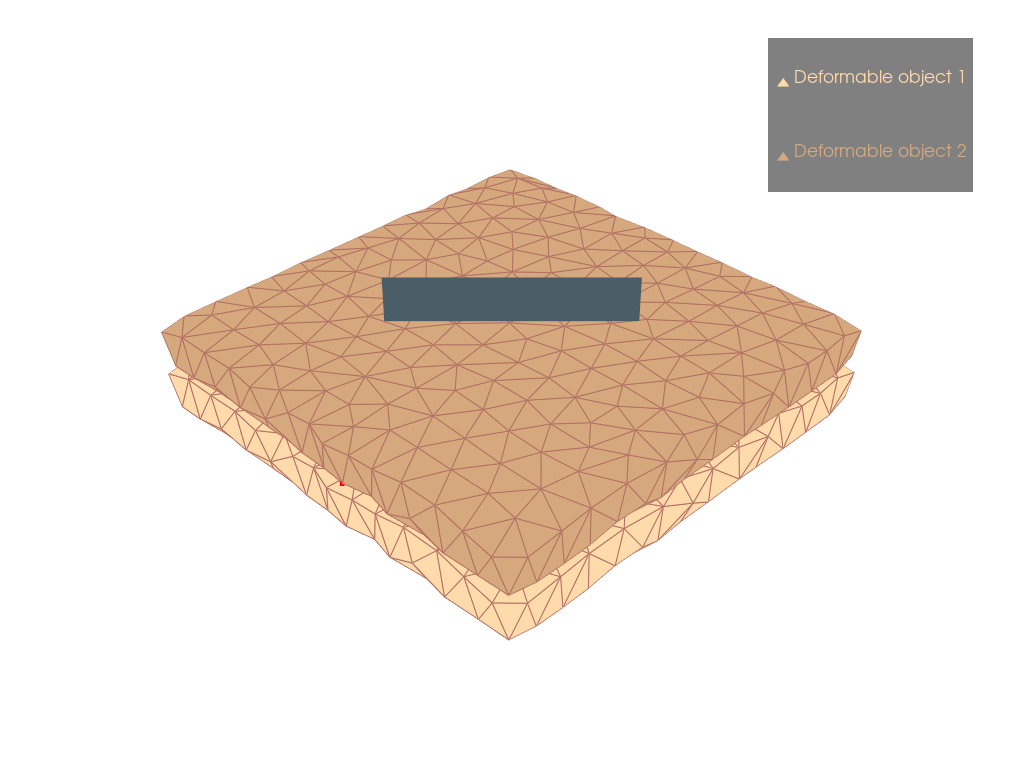

In [7]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
pl.add_mesh(sig_plane)
pl.add_points(softbody.V[softbody.offset_list[1] + 50].cpu().numpy(), color='r')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [8]:
V_origin = softbody.V.clone()
V_velocity_origin = softbody.V_velocity.clone()

In [9]:
softbody.C_boundary_list[0].shape

torch.Size([2115, 2])

In [10]:
# color = np.zeros(400)
# color[306] = 1

In [11]:
cloth_dist_stiffness = 1
V_boundary_stiffness_ref = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * cloth_dist_stiffness
V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*3

In [12]:
filename = 'tissue2tissue_stiffness_' + str(V_boundary_stiffness_ref) + '.gif'
stiffness_text = 'Boundary stiffness = ' + str(V_boundary_stiffness_ref)

In [13]:
select_points = []
for i in range(softbody.V_list[1].shape[0]):
    if (norm_vec @ softbody.V_list[1][i].detach().cpu().numpy()) < 0:
        select_points.append(i + softbody.offset_list[1])

In [14]:
reveal_points = []
for i in softbody.C_boundary_V_0[0]:
    if i in select_points:
        reveal_points.append(i)

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


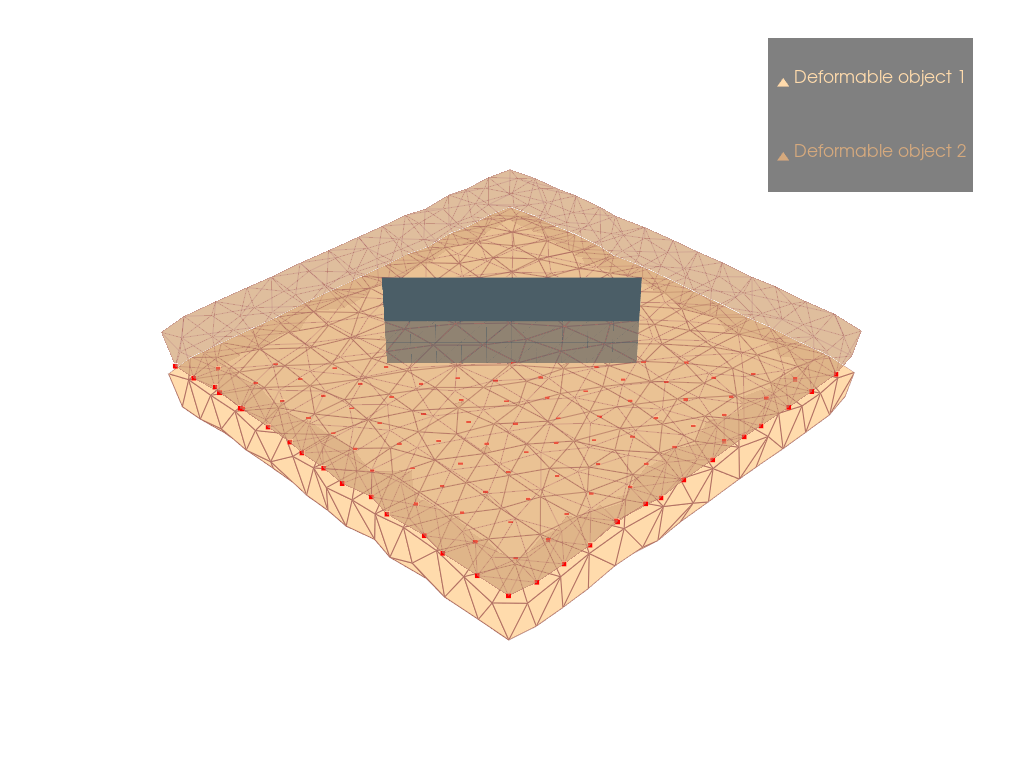

In [15]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2', opacity=0.5)
pl.add_mesh(sig_plane)
pl.add_points(softbody.V[reveal_points].cpu().numpy(), color='r')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [16]:
boundary_mask = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * 0.1
for i in reveal_points:
    idx = torch.where(softbody.C_boundary_V_0[0] == i)[0]
    # print(idx)
    boundary_idx = softbody.C_boundary_lut_0[0][idx]
    boundary_mask[boundary_idx] = 1e-8

In [17]:
softbody.V[softbody.offset_list[1] + 50]

tensor([0.0099, 0.0014, 0.0013])

In [18]:
# Set grad parameter
spline_control.requires_grad_(True)

tensor([[0.0099, 0.0014, 0.0023],
        [0.0099, 0.0014, 0.0033],
        [0.0099, 0.0014, 0.0043]], dtype=torch.float64, requires_grad=True)

In [19]:
optimizer = torch.optim.Adam([spline_control], lr=0.001)

In [20]:
# define loss function
# target = torch.ones_like(V_boundary_stiffness) * 1e-5

def loss_fn(predict, target):
    return torch.norm(target - predict)

In [21]:
## evaluation function
def eval(predict, target):
    predict_revealed = predict < 1e-2
    predict_unrevealed = predict > 1e-2
    # print(torch.sum(predict_revealed))
    target_revealed = target < 1e-2
    target_unrevealed = target > 1e-2

    # calculate arrcuary reveal
    reveal_acc = torch.sum(torch.logical_and(predict_revealed, target_revealed)) / torch.sum(target_revealed)
    unreveal_acc = torch.sum(torch.logical_and(predict_unrevealed, target_unrevealed)) / torch.sum(target_unrevealed)

    return reveal_acc, unreveal_acc

In [22]:
softbody.V[softbody.offset_list[1] + 306]

tensor([-0.0008, -0.0059,  0.0030])

In [23]:
# torch.autograd.set_detect_anomaly(False)
softbody.C_boundary_list[0].shape

torch.Size([2115, 2])

itr 0


100%|██████████| 13/13 [00:13<00:00,  1.06s/it]


loss: tensor(2.9340, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.0891), tensor(1.))
tensor([[ 14.5495, -10.0689,  28.7970],
        [  7.3504, -11.0308,  19.4447],
        [-14.3089,  -1.1085, -22.5622]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


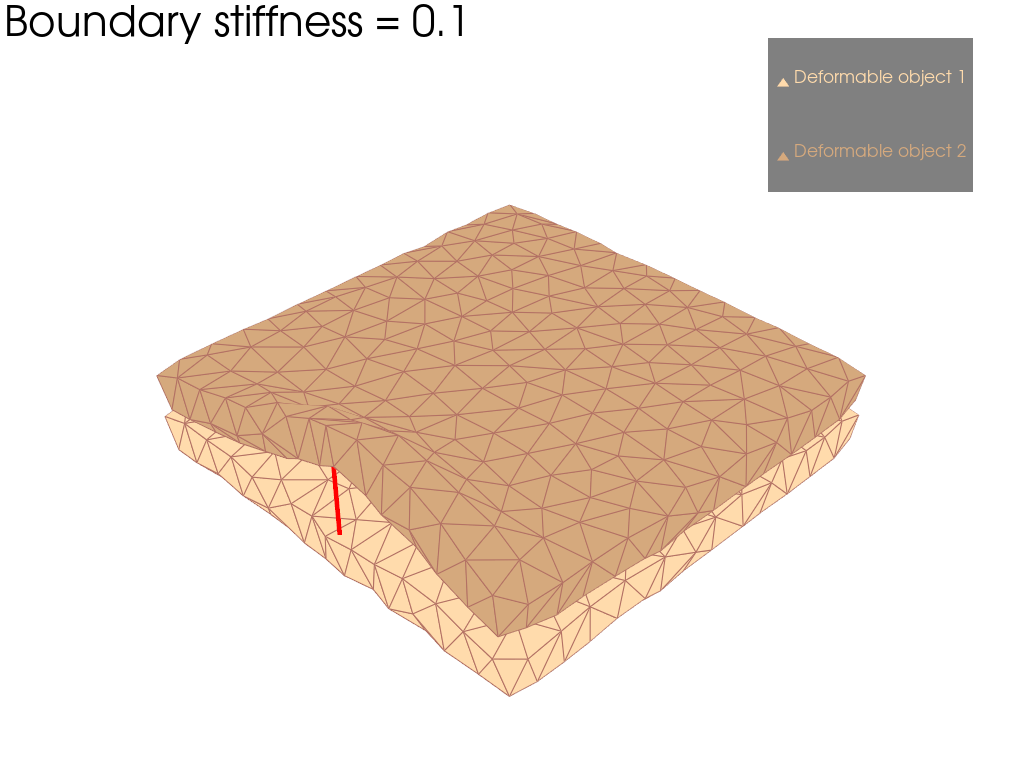

itr 1


100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


loss: tensor(2.6568, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.1978), tensor(0.9961))
tensor([[-81.8026,  57.9740, -54.9742],
        [-34.3951,  32.2135, -15.3799],
        [ 39.4637,  37.8728, -38.4221]], dtype=torch.float64)
itr 2


100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


loss: tensor(2.5054, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.2386), tensor(0.9981))
tensor([[-99.4601,  89.1715,  -5.1979],
        [-40.4520,  36.2984,   2.7447],
        [-87.3277,  95.4335,  18.8682]], dtype=torch.float64)
itr 3


100%|██████████| 22/22 [00:30<00:00,  1.40s/it]


loss: tensor(2.2155, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.3324), tensor(0.9961))
tensor([[  73.9048,  -73.2923,    8.1651],
        [  21.9388,    5.2800,    3.0695],
        [-208.6035,  177.9854,   33.4119]], dtype=torch.float64)
itr 4


100%|██████████| 24/24 [00:35<00:00,  1.46s/it]


loss: tensor(1.7774, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.4698), tensor(0.9855))
tensor([[  31.4865,  -31.3455,   -6.3401],
        [  -1.1023,   -6.1410,   -2.8028],
        [-124.7846,   86.3380,   29.2599]], dtype=torch.float64)
itr 5


100%|██████████| 25/25 [00:33<00:00,  1.34s/it]


loss: tensor(1.7614, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.6713), tensor(0.9326))
tensor([[-16.1786,  38.9180,  14.1098],
        [ 22.5080,  79.0858,  20.6804],
        [305.5523,  92.9459, -59.9145]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


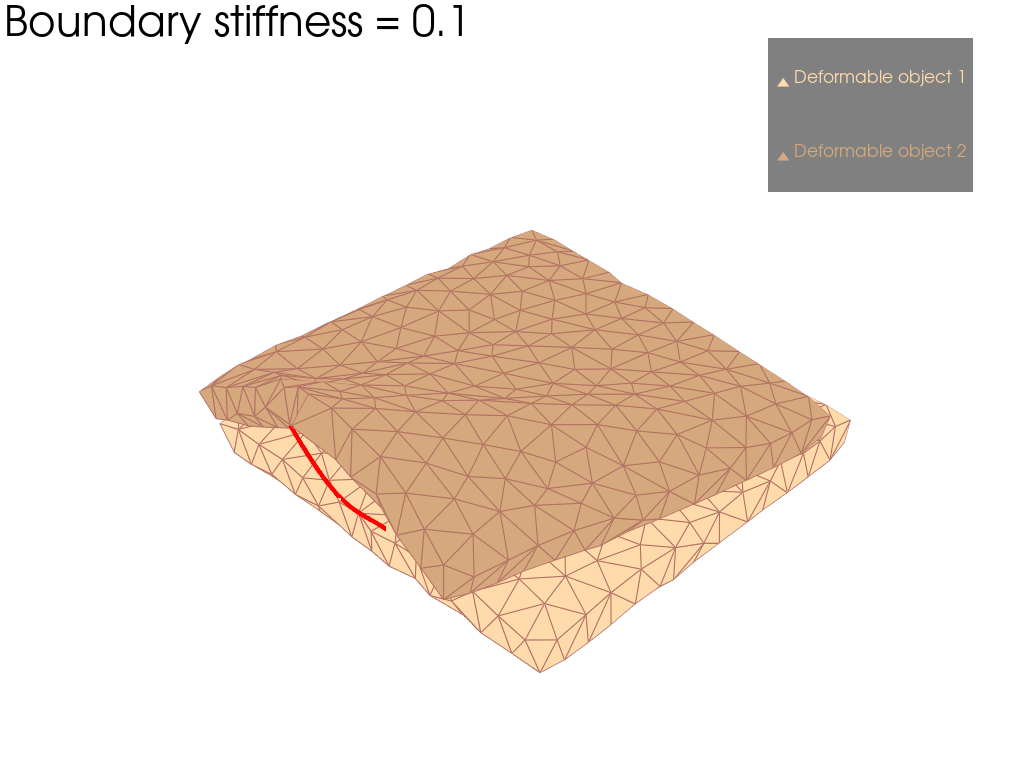

itr 6


100%|██████████| 27/27 [00:33<00:00,  1.25s/it]


loss: tensor(1.7831, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
Accuracy: (tensor(0.7549), tensor(0.8892))
tensor([[-24.8206,  57.1455,  34.7933],
        [ 59.3469, 133.9782,  53.2213],
        [421.5437, 111.8682, -53.0657]], dtype=torch.float64)
itr 7


 55%|█████▍    | 17/31 [00:25<00:20,  1.49s/it]


KeyboardInterrupt: 

In [24]:
spline_list = []
# pl.open_gif(filename)
for t in range(60):
    print('itr', t)
    # get cubic bezier spline control after step
    x_con = torch.cat((start_point[:, 0], spline_control[:, 0]))
    y_con = torch.cat((start_point[:, 1], spline_control[:, 1]))
    z_con = torch.cat((start_point[:, 2], spline_control[:, 2]))
    spline = cubic_bezier_arc_3D(x_con, y_con, z_con, 0.00025)
    spline_x = spline[0]
    spline_y = spline[1]
    spline_z = spline[2]
    spline_trajectory = torch.transpose(torch.vstack((spline_x, spline_y, spline_z)), 0, 1)
    # print(spline_trajectory)
    # restore original vertex and velocity
    softbody.V = V_origin.clone()
    softbody.V_velocity = V_velocity_origin.clone()

    # restore stiffness
    cloth_dist_stiffness = 1
    V_boundary_stiffness_ref = 0.1
    V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
    V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
    V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*0.0005
    
    for i in trange(spline_trajectory.shape[0]):
    # for i in range(1):
        softbody.V[softbody.offset_list[1] + 50] = spline_trajectory[i]
        
        step_ref = XPBDStep(softbody,
                    V_dist_stiffness=V_dist_stiffness, 
                    V_shape_stiffness=V_shape_stiffness,
                    V_boundary_stiffness=V_boundary_stiffness, 
                    dt=cfg.dt,
                    substep=cfg.substep,
                    iteration=cfg.iteration,
                    quasi_static=cfg.quasi_static,
                    plane_height=cfg.ground_plane_height, 
                    use_shape_matching=False,
                    use_spring_boundary=True,
                    use_dist=True)
        V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
        softbody.V = V_ref.clone()
        softbody.V_velocity = V_velocity_ref.clone()
        # print((softbody.V == torch.inf).any())
        ref_V_boundary_stiffness = V_boundary_stiffness.clone()
        energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
        V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(1e9 * (1e-8 - energy)) + 1e-8 * torch.sigmoid(1e9 * (energy - 1e-8))
        skin_mesh.points = softbody.V[:N_skin].detach().cpu().numpy()
        bandage_mesh.points = softbody.V[N_skin:N_bandage+N_skin].detach().cpu().numpy()
    # loss = torch.norm(V_boundary_stiffness)
    loss = loss_fn(V_boundary_stiffness, boundary_mask)
    # loss = torch.norm(V_ref)
    # loss = loss_fn(softbody.V[softbody.offset_list[1] + 305], target)
    loss.backward()
    print('loss:', loss)
    print('Accuracy:', eval(V_boundary_stiffness, boundary_mask))
    print(spline_control.grad)
    spline_list.append(spline_trajectory)
    if t % 5 == 0:
        pl = pv.Plotter()
        pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
        pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
        pl.add_lines(spline_trajectory.detach().cpu().numpy(), connected=True, color='r')
        pl.add_text(stiffness_text)
        # pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
        pl.add_legend()
        pl.camera_position = 'iso'
        pl.show()
        
    optimizer.step()
    optimizer.zero_grad()

# pl.close()

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


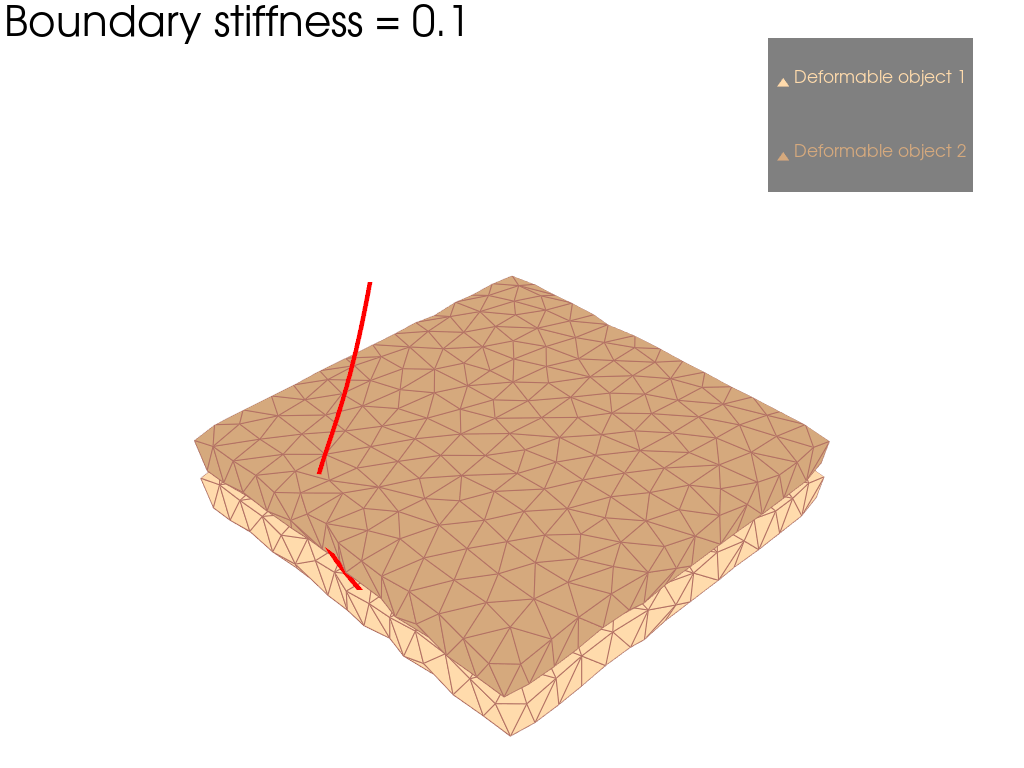

In [ ]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
pl.add_lines(spline_trajectory.detach().cpu().numpy(), connected=True, color='r')
pl.add_text(stiffness_text)
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [ ]:
softbody.V[softbody.offset_list[1] + 306]

tensor([-1.0229e-03,  5.7768e-05,  1.1302e-02], grad_fn=<SelectBackward0>)

In [ ]:
eval(V_boundary_stiffness, boundary_mask)

(tensor(0.8360), tensor(0.9926))

In [ ]:
V_boundary_stiffness

tensor([[9.4485e-04],
        [9.4698e-04],
        [9.3623e-04],
        [9.7842e-04],
        [9.8724e-04],
        [9.8201e-04],
        [1.9218e-04],
        [9.3429e-04],
        [9.5992e-04],
        [9.8038e-04],
        [9.8914e-04],
        [9.5872e-04],
        [2.2353e-04],
        [1.0824e-03],
        [9.4307e-04],
        [9.4300e-04],
        [9.7951e-04],
        [9.3499e-04],
        [9.4029e-04],
        [9.5905e-04],
        [9.8034e-04],
        [6.8837e-06],
        [1.0761e-05],
        [1.2832e-04],
        [9.3224e-04],
        [4.9398e-05],
        [8.5261e-05],
        [9.8534e-04],
        [9.8404e-04],
        [1.2763e-03],
        [1.5155e-03],
        [1.6021e-03],
        [9.4876e-04],
        [2.7137e-03],
        [9.8383e-04],
        [9.8971e-04],
        [9.5230e-04],
        [1.0285e-03],
        [1.1250e-03],
        [9.9116e-04],
        [9.3733e-04],
        [1.0824e-03],
        [9.4275e-04],
        [1.1891e-03],
        [9.4566e-04],
        [9